In [ ]:
#reference pytorch

np.arange(3.0)

x = torch.empty(5,3) # will have some junk
print(x[0,0])

torch.zeros_like(x)
torch.zeros(5,3)

y = torch.rand(5,3)
print(y)

x.size()

torch.tensor([2,1,4])

torch.add(x,y)

z = torch.tensor([1.234])
z.item() #will work for one item to extract out

In [ ]:
"""
NEVER RUN THIS
"""

# input data 1
assert(1==0)

path = '11_ds_1/'
class_names = os.listdir(path)
print(class_names)
data = []
target = []

for cn in range(len(class_names)):
    for fname in os.listdir(path+class_names[cn]+'/'):
        data.append(np.loadtxt(path+class_names[cn]+'/'+fname).flatten())
        target.append(int(cn)) 
print(np.shape(data))
        
# test train split

train_data, test_data, train_target, test_target = train_test_split(data,target,test_size=0.2)
np.save(path+'class_names.npy', class_names)
np.save(path+'train_data.npy', train_data)
np.save(path+'test_data.npy', test_data)
np.save(path+'test_target.npy', test_target)
np.save(path+'train_target.npy', train_target)
print('saved')

In [ ]:
"""
NEVER RUN THIS
"""

# input data 2
assert(1==0)

path = '11_ds_2/'
class_names = os.listdir(path)
print(class_names)
data = []
target = []
for cn in range(len(class_names)):
    data.append(np.genfromtxt(path+class_names[cn], delimiter=','))
s = np.shape(data)
print(s)
for i in range(s[0]):
    for j in range(s[1]):
        target.append(i)
data = np.reshape(data,(s[0]*s[1],s[2]))
print(np.shape(data),np.shape(target))

# test train split

train_data, test_data, train_target, test_target = train_test_split(data,target,test_size=0.2)
np.save(path+'class_names.npy', class_names)
np.save(path+'train_data.npy', train_data)
np.save(path+'test_data.npy', test_data)
np.save(path+'test_target.npy', test_target)
np.save(path+'train_target.npy', train_target)
print('saved')

In [1]:
# imports

import numpy as np
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn import decomposition
import torch.optim as optim
from confusion_matrix import ConfusionPlots

In [2]:
# task1

    Notes
    1. Took whole file as single dim for ds1
    2. The dim reduction with auto associative nural net should be having better performance because it reduces dimension in non linear ways compared to that of PCA 

In [3]:
dir_path = '11_ds_1/'
class_names = np.load(dir_path+'class_names.npy')
train_data = np.load(dir_path+'train_data.npy')
train_target = np.load(dir_path+'train_target.npy')
test_data = np.load(dir_path+'test_data.npy')
test_target = np.load(dir_path+'test_target.npy')
print(np.shape(train_data),np.shape(test_data))
print(class_names)

(1329, 828) (333, 828)
['coast' 'forest' 'insidecity' 'mountain' 'street']


In [4]:
# parameters

dim = 500
h1_dim = 50
out_dim = len(class_names)
learning_rate = 0.001
num_epochs = 600
momentum = 0.9
batch_size = 32  # general rule is to try 32, 64, 128 ...

In [5]:
# PCA

pca = decomposition.PCA(n_components = 500)
pca.fit(train_data)
print(np.shape(train_data))
train_data_pca = pca.transform(train_data)
test_data_pca = pca.transform(test_data)
print(np.shape(train_data))

(1329, 828)
(1329, 828)


In [4]:
# MLFFNN model

class MLFFNN(nn.Module):
    
    def __init__(self):
        super(MLFFNN, self).__init__()
        self.fc1 = nn.Linear(dim,h1_dim) # linear -> fully connected layers
        self.fc2 = nn.Linear(h1_dim,out_dim)
        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
# loss fun and update method

tensor_train_data = torch.Tensor(train_data_pca)
tensor_train_target = torch.LongTensor(train_target) # long otherwise takes as float
 
tensor_test_data = torch.Tensor(test_data_pca)
tensor_test_target = torch.LongTensor(test_target)

# num_workers - how many parallel data loadings
train_dataset = torch.utils.data.TensorDataset(tensor_train_data,tensor_train_target)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=8)

test_dataset = torch.utils.data.TensorDataset(tensor_test_data,tensor_test_target)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False,num_workers=8)

net = MLFFNN()
criterion = nn.CrossEntropyLoss()
# ASDG for generalised delta ig
# schochastic gradient descent with nestrov momentum
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
# optimizer = optim.Adagrad(net.parameters(), lr=learning_rate,lr_decay=0)

In [ ]:
# training


running_loss = 0.0
count = 0
for epoch in range(num_epochs):
    
    for i, load_data in enumerate(train_loader):
        
        inputs, labels = load_data
        
        # initialize with zeros all param
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
        
    if((epoch+1)%50 == 0):
        print(epoch+1, running_loss/count)
        running_loss = 0.0
        count = 0

In [8]:
# retrive saved net

net = MLFFNN()
net.load_state_dict(torch.load('net1_task1.pth'))

<All keys matched successfully>

train accuracy:0.9932279909706546


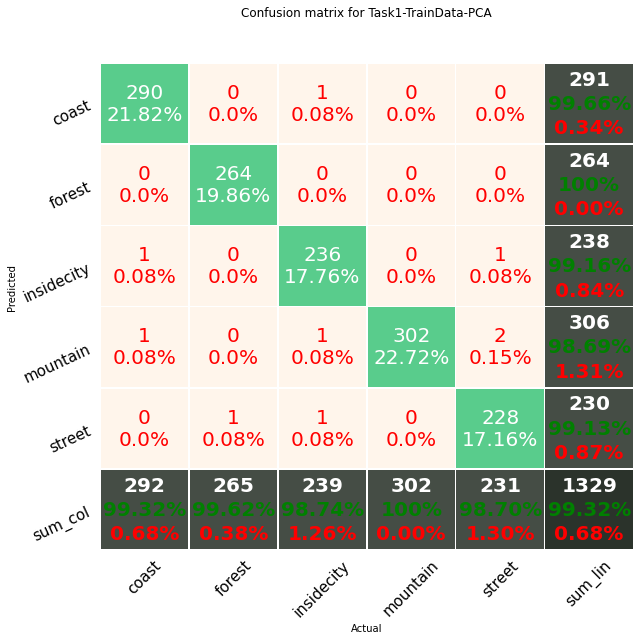

test accuracy:0.7027027027027027


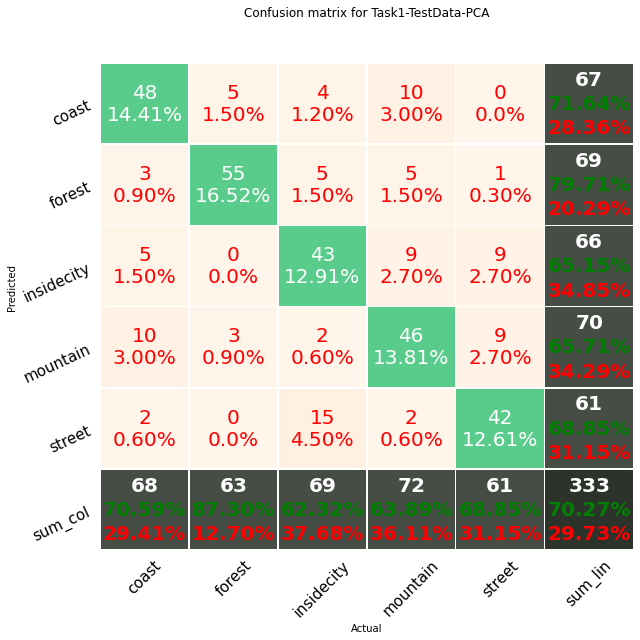

In [10]:
# testing

# train data
correct = 0
total = 0
preds = []
tgts = []
with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        preds.extend(predicted)
        tgts.extend(labels)
print('train accuracy',end=':')
print(correct/total)

ConfusionPlots.pretty_conf(tgts,preds,'Task1-TrainData-PCA',columns=class_names)

#test data
correct = 0
total = 0
preds = []
tgts = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        preds.extend(predicted)
        tgts.extend(labels)
print('test accuracy',end=':')
print(correct/total)

ConfusionPlots.pretty_conf(tgts,preds,'Task1-TestData-PCA',columns=class_names)

In [ ]:
# save 
# model1 is saved after fine tuning

saved_net_path = 'net1_task1.pth'
torch.save(net.state_dict(),saved_net_path)

In [5]:
dim = 828
h1_dim = 1000
h2_dim = 800
h3_dim = 500
h4_dim = 900
batch_size = 64
learning_rate = 0.001
num_epochs = 2500
num_workers = 8

In [6]:
# AANN

class AANN(nn.Module):
    def __init__(self):
        super(AANN, self).__init__()
        self.fc1 = nn.Linear(dim,h1_dim)
        self.fc2 = nn.Linear(h1_dim,h2_dim)
        self.fc5 = nn.Linear(h2_dim, h3_dim)
        self.fc3 = nn.Linear(h3_dim,h4_dim)
        self.fc4 = nn.Linear(h4_dim,dim)
        
    def forward(self, x):
        m = nn.Tanh()
        x = self.fc1(x)
        x = m(self.fc2(x))
        y = self.fc5(x)
        x = m(self.fc3(y))
        x = self.fc4(x)
        return x, y

In [20]:
# training for AANN

tensor_data = torch.Tensor(train_data)
tensor_data_test = torch.Tensor(test_data)

dataset = torch.utils.data.TensorDataset(tensor_data,tensor_data)
dataset_test = torch.utils.data.TensorDataset(tensor_data_test,tensor_data_test)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers=num_workers)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size,shuffle=True,num_workers=num_workers)

aann = AANN()
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adagrad(aann.parameters(), lr=learning_rate,lr_decay=0)

In [69]:
running_loss = 0.0
count = 0
for epoch in range(num_epochs):
    
    for i, load_data in enumerate(loader):
        
        inputs, same_inputs = load_data
        
        # initialize with zeros all param
        optimizer.zero_grad()
        
        outputs,_ = aann(inputs)
        loss = criterion(outputs,same_inputs)
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
        
    if((epoch+1)%50 == 0):
        print(epoch+1, running_loss/count)
        running_loss = 0.0
        count = 0

50 0.15279945030808448
100 0.0996044040790626
150 0.07491858116218023
200 0.06031742529854888
250 0.05063085545386587
300 0.04352663475487913
350 0.03819169722497463
400 0.03408134112932852
450 0.030872396007180215
500 0.02823345779308251
550 0.02604434430244423
600 0.024248899675550915
650 0.022812419847718306
700 0.02158778453511851
750 0.0205350241721386
800 0.01962142920387643
850 0.01881332423360575
900 0.018106598774237294
950 0.0174860216198223
1000 0.016919009455790123
1050 0.0164170536115056
1100 0.015955349818936416
1150 0.015554602594070491
1200 0.0151824130295288
1250 0.014837323159334205
1300 0.014532619502750182
1350 0.014242005979730969
1400 0.013972918422271809
1450 0.013713619704580023
1500 0.013470882572943255
1550 0.013248950501105614
1600 0.013039961491844484
1650 0.01284894863764445
1700 0.01265991496897879
1750 0.012478910398093008
1800 0.012312494230767091
1850 0.012149605099998769
1900 0.011989272083377554
1950 0.01183734665669146
2000 0.011684321065743764
2050 

In [7]:
aann = AANN()
aann.load_state_dict(torch.load('aann_task1.pth'))

<All keys matched successfully>

In [22]:
error = 0
num = 0
with torch.no_grad():
    for data in loader:
        inputs, labels = data
        outputs,_ = aann(inputs)
        diff = outputs-inputs
        error += ((diff*diff).sum().item())
        num += 1
print('Train error',end=':')
print(error/(num*dim))

error = 0
num = 0
with torch.no_grad():
    for data in loader_test:
        inputs, labels = data
        outputs,_ = aann(inputs)
        diff = outputs-inputs
        error += ((diff*diff).sum().item())
        num += 1
print('Test error',end=':')
print(error/(num*dim))

Train error:0.6507938736906155
Test error:1.22992442464291


In [71]:
torch.save(aann.state_dict(),'aann_task1.pth')

In [8]:
aann_train = torch.Tensor(train_data)
aann_test = torch.Tensor(test_data)

In [9]:
with torch.no_grad():
    print(aann_train.size())
    _, aann_train = aann(aann_train)
    _, aann_test = aann(aann_test)
    print(aann_train.size())

torch.Size([1329, 828])
torch.Size([1329, 500])


In [10]:
# parameters

dim = 500
h1_dim = 50
out_dim = len(class_names)
learning_rate = 0.001
momentum = 0.9
num_workers = 8
num_epochs = 1000
batch_size = 32  # general rule is to try 32, 64, 128 ...

In [11]:
# loss fun and update method

tensor_train_target = torch.LongTensor(train_target) # long otherwise takes as float

tensor_test_target = torch.LongTensor(test_target)

# num_workers - how many parallel data loadings
train_dataset = torch.utils.data.TensorDataset(aann_train,tensor_train_target)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=num_workers)

test_dataset = torch.utils.data.TensorDataset(aann_test,tensor_test_target)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=False,num_workers=num_workers)

net2 = MLFFNN()
criterion = nn.CrossEntropyLoss()
# ASDG for generalised delta ig
# schochastic gradient descent with nestrov momentum
optimizer = optim.SGD(net2.parameters(), lr=learning_rate, momentum=momentum)
# optimizer = optim.Adagrad(net.parameters(), lr=learning_rate,lr_decay=0)

In [12]:
# training


running_loss = 0.0
count = 0
for epoch in range(num_epochs):
    
    for i, load_data in enumerate(train_loader):
        
        inputs, labels = load_data
        
        # initialize with zeros all param
        optimizer.zero_grad()
        
        outputs = net2(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
        
    if((epoch+1)%50 == 0):
        print(epoch+1, running_loss/count)
        running_loss = 0.0
        count = 0

50 1.3643631518170947
100 0.8197279421488444
150 0.6036450883462315
200 0.5138805822389466
250 0.46104637900278683
300 0.4210758592578627
350 0.38518427288248425
400 0.35020145375813755
450 0.3155190295264834
500 0.2803471720928238
550 0.24616964929160617
600 0.2135731387972122
650 0.18393505338934205
700 0.15725930586989437
750 0.13436303396842308
800 0.11517843209029663
850 0.09927105261279004
900 0.08598635004655945
950 0.07506715055643802
1000 0.06622775200310917


In [27]:
net2 = MLFFNN()
net2.load_state_dict(torch.load('net2_task1.pth'))

<All keys matched successfully>

train accuracy:1.0


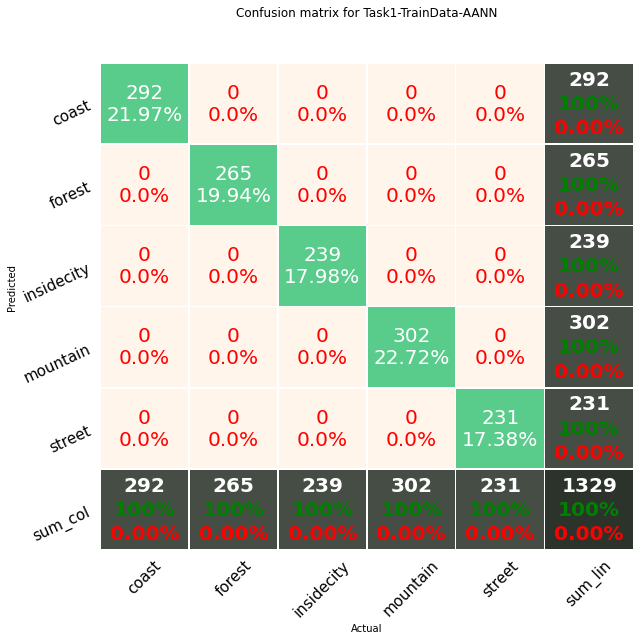

test accuracy:0.6576576576576577


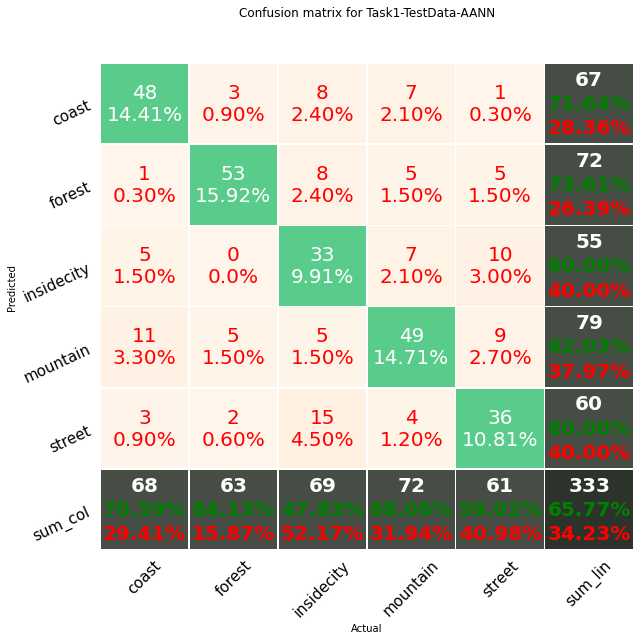

In [13]:
# testing

# train data
correct = 0
total = 0
preds = []
tgts = []
with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        outputs = net2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        preds.extend(predicted)
        tgts.extend(labels)
print('train accuracy',end=':')
print(correct/total)

ConfusionPlots.pretty_conf(tgts,preds,'Task1-TrainData-AANN',columns=class_names)

#test data
correct = 0
total = 0
preds = []
tgts = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        preds.extend(predicted)
        tgts.extend(labels)
print('test accuracy',end=':')
print(correct/total)

ConfusionPlots.pretty_conf(tgts,preds,'Task1-TestData-AANN',columns=class_names)

train accuracy:0.9699021820917983


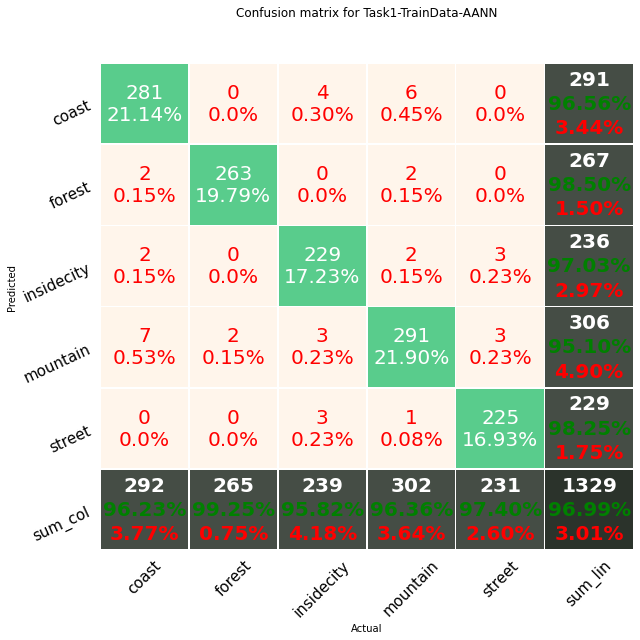

test accuracy:0.6516516516516516


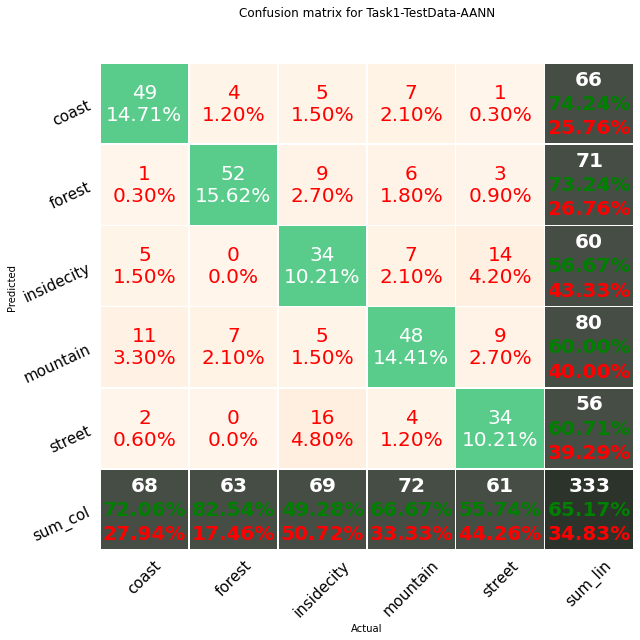

In [28]:
# testing

# train data
correct = 0
total = 0
preds = []
tgts = []
with torch.no_grad():
    for data in train_loader:
        inputs, labels = data
        outputs = net2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        preds.extend(predicted)
        tgts.extend(labels)
print('train accuracy',end=':')
print(correct/total)

ConfusionPlots.pretty_conf(tgts,preds,'Task1-TrainData-AANN',columns=class_names)

#test data
correct = 0
total = 0
preds = []
tgts = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net2(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        preds.extend(predicted)
        tgts.extend(labels)
print('test accuracy',end=':')
print(correct/total)

ConfusionPlots.pretty_conf(tgts,preds,'Task1-TestData-AANN',columns=class_names)

In [29]:
torch.save(net2.state_dict(),'net2_task1.pth')